In [1]:
import os
import subprocess
import sys
import pickle
import copy
import math
import scipy

import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# plt.rc('text', usetex=True)
import multiprocessing as mp

from scipy.signal import savgol_filter as savgol
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d
from matplotlib import gridspec
from importlib import reload

# sns.set(style="darkgrid")
%matplotlib inline

# sys.path.insert(0, 'D:\Git')
# sys.path.insert(0, '/home/tristan/git/')
# from FDSInput.data_structures import FDSMESH
# from FDSInput.data_structures import FDSOBST
# from FDSInput.data_structures import FDSSURF
# from FDSInput.data_structures import FDSMATL

# from UsefulStuff.UsefulStuffPython import plot_exp_mod_sim


# sys.path.insert(0, '../GeneralInformation/')
# from SimHandling import exchange_placeholder
# from SimHandling import save_file
# from SimHandling import run_job
# from SimHandling import box_plot
# from SimHandling import plot_exp_mod_sim

# from RunFDSJobs import run_job_mp

# import GeneralSimInfo as GSI
# reload(GSI)

In [2]:
print('Package Versions')
print('----------------')
print('Pandas version: {}'.format(pd.__version__))
print('Numpy version: {}'.format(np.__version__))
print('Matplotlib version: {}'.format(matplotlib.__version__))
print('SciPy version: {}'.format(scipy.__version__))

Package Versions
----------------
Pandas version: 0.24.1
Numpy version: 1.15.4
Matplotlib version: 3.0.2
SciPy version: 1.2.1


In [3]:
cwd = os.getcwd()
print(cwd)

D:\Git\UsefulStuff\LabEquipment\FDSConeRAMP


# General Information

In [4]:
cone_file = os.path.join('..', 'ConeFTT', 'ExperimentalData', 
                         'ConeExtract.csv')

# Read Cone Data

In [5]:
cone_data = pd.read_csv(cone_file)
cone_data.head()

,Time (s),HRR (kW/m2),MLR (g/s),Specimen mass (g)
0,0,1.004885,0.888066,106.400000
1,1,0.821132,-0.501073,106.414472
2,2,0.578730,-0.171946,106.829391
3,3,0.486264,0.130683,106.703843
4,4,0.344294,0.071574,106.651622


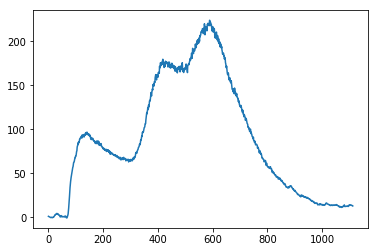

In [6]:
plt.plot(cone_data['Time (s)'],
         cone_data['HRR (kW/m2)'])

# Process Data

## Find Local Extrema

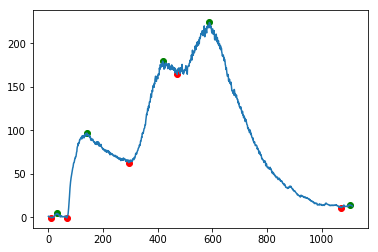

In [7]:
# Adopted from: 
# https://stackoverflow.com/questions/48023982/pandas-finding-local-max-and-min?rq=1

# number of points to be checked before and after 
n=40 

# Set DataFrame and desired column.
df = cone_data
column_label = 'HRR (kW/m2)'

# Find local peaks
df['min'] = df.iloc[argrelextrema(df[column_label].values, 
                                  np.less_equal, 
                                  order=n)[0]][column_label]
df['max'] = df.iloc[argrelextrema(df[column_label].values, 
                                  np.greater_equal, 
                                  order=n)[0]][column_label]

# Plot results
plt.scatter(df.index, df['min'], c='r')
plt.scatter(df.index, df['max'], c='g')
plt.plot(df.index, df[column_label]);

## Interpolate Data

Data points: 1113


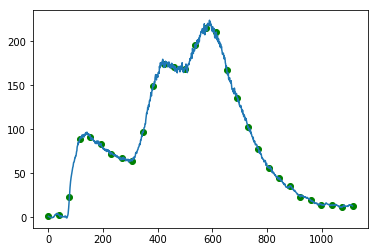

In [8]:
# Number of data points to be used for the RAMP.
n=30 

# Set DataFrame and desired column.
df = cone_data
column_label_x = 'Time (s)'
column_label_y = 'HRR (kW/m2)'

data_points = len(df[column_label_y])
print('Data points: {}'.format(data_points))

# Calculate the new x values to be used for the interpolation.
x_vals = np.linspace(0, data_points, n, endpoint=True)

# Interpolate the data series based on the new x-values.
# Incorporate the last data point (df.tail(1)).
interpolated_y = np.interp(x=x_vals,
                           xp=df[column_label_x],
                           fp=df[column_label_y], 
                           right=df[column_label_y].tail(1))

# Collect new data points in DataFrame.
ramp_df = pd.DataFrame({'Time': x_vals,
                        'HRR': interpolated_y})

# Plot results.
plt.scatter(ramp_df.Time, ramp_df.HRR, c='g')
plt.plot(df[column_label_x], df[column_label_y]);

## Combine Data Points

In [9]:
# Get local extrema.
local_extrema = [cone_data['min'].notnull(),
                 cone_data['max'].notnull()]

for extrema in local_extrema:
    for id_extr, extremum in enumerate(extrema):
        # Find location of extremum.
        if extremum:
            hrr_val = cone_data.iloc[id_extr]['HRR (kW/m2)']
            
            # Prevent negative values to be chosen.
            if hrr_val < 0:
                new_time = cone_data.iloc[id_extr]['Time (s)']
                new_hrr = np.float64(0.0)
            else:
                new_time = cone_data.iloc[id_extr]['Time (s)'] 
                new_hrr = cone_data.iloc[id_extr]['HRR (kW/m2)']
            
            # Create DataFrame of new row to be inserted into 
            # the DataFrame with the interpolated values.
            new_row = pd.DataFrame({'Time': new_time,
                                    'HRR': new_hrr},
                                   index=[0])
            
            # Add new row into the interpolated DataFrame.
            ramp_df = pd.concat([new_row, ramp_df]).reset_index(drop=True)             

# Sort DataFrame by the time values.
ramp_df = ramp_df.sort_values(by=['Time']).reset_index(drop=True) 

# Create RAMP Input

In [10]:
hrrpua_max = cone_data['HRR (kW/m2)'].max()
hrrpua_max

224.093411120374

In [11]:
def create_hrrpua_ramp(surf_id, hrrpua, time, function_value, ramp_id=None,
                       spec_id='PROPANE', color='RASPBERRY', ignition_temp=None):
    # Nuclei for the input lines.
    hrrpua_surf_nucleus = "&SURF ID='{}', SPEC_ID(1)='{}', HRRPUA={}, COLOR='{}', RAMP_Q='{}'{}/"
    ramp_nucleus = "&RAMP ID='{}', T={}, F={}/"
    ignition_nucleus = ", IGNITION_TEMPERATURE = {} "
    
    # Initialise list to store the input lines.
    input_lines=list()
    
    # Check if ignition temperature was provided.
    if ignition_temp is None:
        ignition_temp=' '
    
    # Check if RAMP_ID was provided.
    if ramp_id is None:
        ramp_id = 'BURNER_RAMP'
        
    # Build SURF input line.
    hrrpua_surf = hrrpua_surf_nucleus.format(surf_id, spec_id, hrrpua, color, ramp_id, ignition_temp)
    input_lines.append(hrrpua_surf)
    input_lines.append('')
    input_lines.append('')
    input_lines.append('')
    
    # Build the RAMP input lines.
    for id_time, time_val in enumerate(time):
        f_val = function_value[id_time] / hrrpua
        ramp_line = ramp_nucleus.format(ramp_id, time_val, f_val)
        input_lines.append(ramp_line)
        
    
    # Return the list of input lines.
    return input_lines

In [12]:
ramp_input = create_hrrpua_ramp(surf_id='BURNER', hrrpua=hrrpua_max, time=ramp_df.Time, 
                                function_value=ramp_df.HRR, ramp_id=None,
                                spec_id='PROPANE', color='RASPBERRY', ignition_temp=None)

In [13]:
for line in ramp_input:
    print(line)

&SURF ID='BURNER', SPEC_ID(1)='PROPANE', HRRPUA=224.093411120374, COLOR='RASPBERRY', RAMP_Q='BURNER_RAMP' /



&RAMP ID='BURNER_RAMP', T=0.0, F=0.0044842220111413105/
&RAMP ID='BURNER_RAMP', T=9.0, F=0.0/
&RAMP ID='BURNER_RAMP', T=31.0, F=0.01938252678045156/
&RAMP ID='BURNER_RAMP', T=38.37931034482759, F=0.011184400722677845/
&RAMP ID='BURNER_RAMP', T=67.0, F=0.0/
&RAMP ID='BURNER_RAMP', T=76.75862068965517, F=0.10118093527143487/
&RAMP ID='BURNER_RAMP', T=115.13793103448276, F=0.3970143962254664/
&RAMP ID='BURNER_RAMP', T=141.0, F=0.43189410225073505/
&RAMP ID='BURNER_RAMP', T=153.51724137931035, F=0.4062699141500272/
&RAMP ID='BURNER_RAMP', T=191.89655172413794, F=0.3735974553972969/
&RAMP ID='BURNER_RAMP', T=230.27586206896552, F=0.3233073126412962/
&RAMP ID='BURNER_RAMP', T=268.65517241379314, F=0.2994635080021613/
&RAMP ID='BURNER_RAMP', T=293.0, F=0.28054853349827075/
&RAMP ID='BURNER_RAMP', T=307.0344827586207, F=0.28781718965485614/
&RAMP ID='BURNER_RAMP', T=345.41379310344826

# Check Result

In [16]:
fds_hrr_file = os.path.join('ConePaintTest_hrr.csv')

fds_hrr_df = pd.read_csv(fds_hrr_file, header=1)
fds_hrr_df.head()

,Time,HRR,Q_RADI,Q_CONV,Q_COND,Q_DIFF,Q_PRES,Q_PART,Q_GEOM,Q_ENTH,Q_TOTAL,MLR_FUEL,MLR_TOTAL
0,0.000000,0.000000,0.000000,1.647987e-20,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,1.647987e-20,0.000000e+00,0.000000e+00
1,2.000000,0.003507,-0.000183,5.555504e-05,-0.000024,-5.772169e-07,0.0,0.0,0.0,0.000602,3.354381e-03,1.820092e-07,1.820092e-07
2,2.401691,0.026982,-0.001430,4.350392e-04,-0.000111,-5.016491e-07,0.0,0.0,0.0,0.005438,2.587662e-02,1.578709e-07,1.578709e-07
3,3.616680,0.010782,-0.001198,1.532813e-04,-0.000492,-4.546805e-07,0.0,0.0,0.0,0.015495,9.244155e-03,1.424154e-07,1.424154e-07
4,4.845472,0.007209,-0.000830,-2.603800e-03,-0.000151,-3.619417e-07,0.0,0.0,0.0,0.003802,3.623992e-03,1.132059e-07,1.132059e-07


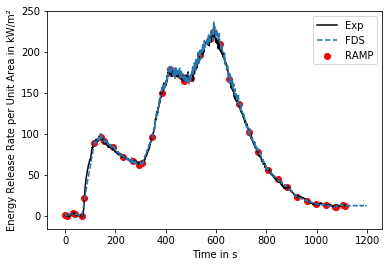

In [17]:
# Plot results
# Experimental data.
plt.plot(df[column_label_x], 
         df[column_label_y], c='k',
         label='Exp')
# Data points of the RAMP.
plt.scatter(ramp_df.Time, ramp_df.HRR, 
            c='r', label='RAMP')
# Response from FDS.
plt.plot(fds_hrr_df.Time,
         fds_hrr_df.HRR/(0.1**2), 
         linestyle='dashed',
         label='FDS');

plt.legend()

# plt.title('Energy Release Rate per Unit Area')
plt.xlabel('Time in s')
plt.ylabel('Energy Release Rate per Unit Area in kW/m²');

## Determine Critical Heat Flux